In [1]:
from fairtorch import ConstraintLoss, DemographicParityLoss, EqualiedOddsLoss

import random
import numpy as np 
import os
import torch 
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(42)

### Prepare synthetic dataset 

In [3]:
n_samples = 512
n_feature = 4 

def generate_data(n_samples=n_samples, n_feature=n_feature):
    
    y = np.random.randint(0,2, size=n_samples)
    loc0 = np.random.uniform(-1,1,n_feature)
    loc1 = np.random.uniform(-1,1,n_feature)
    
    X = np.zeros((n_samples, n_feature))
    for i,u in enumerate(y):
        if y[i]==0:
            X[i] = np.random.normal(loc=loc0,scale=1.0, size=n_feature)
        else:
            X[i] = np.random.normal(loc=loc1, scale=1.0, size=n_feature)
    
    sensitive_feature = (X[:,0]>X[:,0].mean()).astype(int)
    X = torch.from_numpy(X).float()
    y = torch.from_numpy(y).float()
    sensitive_feature = torch.from_numpy(sensitive_feature)
    
    return X, y, sensitive_feature

In [4]:
dataset = generate_data(1024,4)

#### split dataset

In [5]:
n_train = int(0.7 * len(dataset[0]))
X_train, y_train, sensitive_train = map(lambda x: x[:n_train], dataset)
X_test, y_test, sensitive_test = map(lambda x: x[n_train:], dataset)

### non fair model

In [6]:
hidden_size = 32
n_epochs = 50


model = nn.Sequential(nn.Linear(n_feature,1))

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

for param in model.parameters():
    nn.init.normal_(param, 0, 1e-7)

model.train()

for i in range(n_epochs):
    optimizer.zero_grad()
    logit = model(X_train)
    loss = criterion(logit.view(-1), y_train)
    loss.backward()
    optimizer.step()
    
acc_train = ((torch.sigmoid(model(X_train)).view(-1) >0.5).float()==y_train).float().mean().float().item()
acc_test = ((torch.sigmoid(model(X_test)).view(-1) >0.5).float()==y_test).float().mean().float().item()

print('acc train', acc_train)
print('acc test', acc_test)
acc_nonfair_test = acc_test

acc train 0.8743016719818115
acc test 0.8896104097366333


/opt/conda/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


### parity check

In [11]:
y_pred = (torch.sigmoid(model(X_test)).view(-1)>0.5).float()

In [12]:
y_pred = (torch.sigmoid(model(X_test)).view(-1) > 0.5 ).float()

In [13]:
# expected value of y_pred = 1 for each sensitive group
# E[h(X)|A=a]
# correspond to demographic parity
expect_by_a={}
for i in [0,1]:
    idx = sensitive_test==i
    expect_by_a[i] = y_pred[idx].mean().item()
print(expect_by_a)
nonfair_gap = np.abs(expect_by_a[0]-expect_by_a[1])
print(nonfair_gap)

{0: 0.7272727489471436, 1: 0.14935064315795898}
0.5779221057891846


In [14]:
# expected value of y_pred = 1 for each sensitive group and true label
# E[h(X)|A=a, Y=y]
# correspond to equalized odds

expect_by_a_y = {}
expect_by_a_y_list = []

for i in [0, 1]:
    expect_by_a_y[i]={}
    for j in [0, 1]:
        idx= (sensitive_test == i) & (y_test == j)
        expc = y_pred[idx].mean().item()
        expect_by_a_y[i][j] =  expc
        expect_by_a_y_list.append(expc)
print(expect_by_a_y)
vanilla_gap_eo = np.max(expect_by_a_y_list)- np.min(expect_by_a_y_list)
print("gap: ", vanilla_gap_eo)

{0: {0: 0.25, 1: 0.918181836605072}, 1: {0: 0.01652892492711544, 1: 0.6363636255264282}}
gap:  0.9016529116779566


### Demographi parity

#### fairness for dp

In [15]:
model = nn.Sequential(nn.Linear(n_feature,1))
dp_loss = DemographicParityLoss(sensitive_classes=[0,1], alpha=100)
optimizer = optim.SGD(model.parameters(), lr=0.1)

for param in model.parameters():
    nn.init.normal_(param, 0, 1e-7)
model.train()

for i in range(n_epochs):
    optimizer.zero_grad()
    logit = model(X_train)
    loss = criterion(logit.view(-1), y_train)
    #　普通のロスに追加する
    loss += dp_loss(X_train, logit, sensitive_train)
    loss.backward()
    optimizer.step()

In [16]:
acc_train = ((torch.sigmoid(model(X_train)).view(-1) > 0.5 ).float()  == y_train ).float().mean().float().item()
acc_test = ((torch.sigmoid(model(X_test)).view(-1) > 0.5 ).float()  == y_test ).float().mean().float().item()

print("acc train: ", acc_train)
print("acc test: ",acc_test)
acc_test_dp = acc_test

acc train:  0.7150837779045105
acc test:  0.7045454382896423


#### check parity for dp

In [17]:
y_pred = (torch.sigmoid(model(X_test)).view(-1)>0.5).float()

In [18]:
# expected value of y_pred = 1 for each sensitive group
# E[h(X)|A=a]
# correspond to demographic parity
expect_by_a={}
for i in [0,1]:
    idx = sensitive_test==i
    expect_by_a[i] = y_pred[idx].mean().item()
print(expect_by_a)
nonfair_gap = np.abs(expect_by_a[0]-expect_by_a[1])
print(nonfair_gap)

{0: 0.5324675440788269, 1: 0.5064935088157654}
0.025974035263061523


In [27]:
# expected value of y_pred = 1 for each sensitive group and true label
# E[h(X)|A=a, Y=y]
# correspond to equalized odds

expect_by_a_y = {}
expect_by_a_y_list = []

for i in [0, 1]:
    expect_by_a_y[i]={}
    for j in [0, 1]:
        idx= (sensitive_test == i) & (y_test == j)
        expc = y_pred[idx].mean().item()
        expect_by_a_y[i][j] =  expc
        expect_by_a_y_list.append(expc)
print(expect_by_a_y)
vanilla_gap_eo = np.max(expect_by_a_y_list)- np.min(expect_by_a_y_list)
print("gap: ", vanilla_gap_eo)

{0: {0: 0.15909090638160706, 1: 0.6818181872367859}, 1: {0: 0.38842976093292236, 1: 0.939393937587738}}
gap:  0.780303031206131


### Equalied Odds

#### fairness for eo

In [32]:
model = nn.Sequential(nn.Linear(n_feature,1))
eo_loss = EqualiedOddsLoss(sensitive_classes=[0, 1], alpha=100)
optimizer = optim.SGD(model.parameters(),lr=0.1)



for param in model.parameters():
    nn.init.normal_(param, 0, 1e-7)
model.train()

for i in range(0, 50):
    optimizer.zero_grad()    
    logit = model(X_train)
    loss = criterion(logit.view(-1), y_train)
    loss +=  eo_loss(X_train, logit, sensitive_train, y_train)
    loss.backward()
    optimizer.step()


acc_train = ((torch.sigmoid(model(X_train)).view(-1) > 0.5 ).float()  == y_train ).float().mean().float().item()
acc_test = ((torch.sigmoid(model(X_test)).view(-1) > 0.5 ).float()  == y_test ).float().mean().float().item()

print("acc train: ", acc_train)
print("acc test: ",acc_test)
acc_test_eo = acc_test


acc train:  0.7025139927864075
acc test:  0.7532467246055603


#### check parity for dp

In [36]:
y_pred = (torch.sigmoid(model(X_test)).view(-1)>0.5).float()

In [37]:
# expected value of y_pred = 1 for each sensitive group
# E[h(X)|A=a]
# correspond to demographic parity
expect_by_a={}
for i in [0,1]:
    idx = sensitive_test==i
    expect_by_a[i] = y_pred[idx].mean().item()
print(expect_by_a)
nonfair_gap = np.abs(expect_by_a[0]-expect_by_a[1])
print(nonfair_gap)

{0: 0.37012988328933716, 1: 0.12987013161182404}
0.24025975167751312


In [38]:
# expected value of y_pred = 1 for each sensitive group and true label
# E[h(X)|A=a, Y=y]
# correspond to equalized odds

expect_by_a_y = {}
expect_by_a_y_list = []

for i in [0, 1]:
    expect_by_a_y[i]={}
    for j in [0, 1]:
        idx= (sensitive_test == i) & (y_test == j)
        expc = y_pred[idx].mean().item()
        expect_by_a_y[i][j] =  expc
        expect_by_a_y_list.append(expc)
print(expect_by_a_y)
vanilla_gap_eo = np.max(expect_by_a_y_list)- np.min(expect_by_a_y_list)
print("gap: ", vanilla_gap_eo)

{0: {0: 0.0, 1: 0.5181818008422852}, 1: {0: 0.041322313249111176, 1: 0.4545454680919647}}
gap:  0.5181818008422852


### Trade-off between fairness and accuracy

In [42]:
acc_list = []
dp_fairness_list = []
alpha_list = np.logspace(-2, 2, 20)

for alpha in alpha_list:
    model = nn.Sequential(nn.Linear(n_feature,1))
    dp_loss = DemographicParityLoss(sensitive_classes=[0, 1], alpha=alpha)
    optimizer = optim.Adam(model.parameters())


    for param in model.parameters():
        nn.init.normal_(param, 0, 1e-7)
    model.train()

    for i in range(0, 50):
        optimizer.zero_grad()    
        logit = model(X_train)
        loss = criterion(logit.view(-1), y_train)
        loss +=  dp_loss(X_train, logit, sensitive_train)
        loss.backward()
        optimizer.step()


    acc_train = ((torch.sigmoid(model(X_train)).view(-1) > 0.5 ).float()  == y_train ).float().mean().float().item()
    acc_test = ((torch.sigmoid(model(X_test)).view(-1) > 0.5 ).float()  == y_test ).float().mean().float().item()

    acc_test_dp = acc_test
    y_pred = (torch.sigmoid(model(X_test)).view(-1) > 0.5 ).float()
    acc_list.append(acc_test_dp)

    expect_by_a={}
    for i in [0, 1]:
        idx = sensitive_test==i
        expect_by_a[i]=  y_pred[idx].mean().item()
    dp_gap_dp = np.abs(expect_by_a[0] - expect_by_a[1])
    dp_fairness_list.append(dp_gap_dp)

In [43]:
from matplotlib import pyplot as plt

Text(0, 0.5, 'total accuracy')

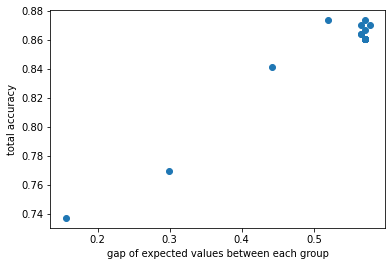

In [44]:

plt.scatter(dp_fairness_list, acc_list)
plt.xlabel("gap of expected values between each group")
plt.ylabel("total accuracy")

Text(0.5, 0, 'alpha (degree of contraint)')

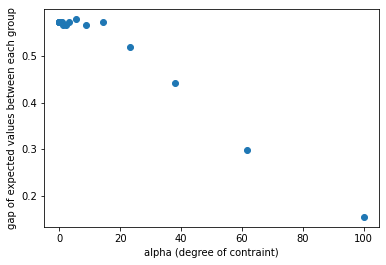

In [45]:

plt.scatter(alpha_list, dp_fairness_list)
plt.ylabel("gap of expected values between each group")
plt.xlabel("alpha (degree of contraint)")